In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not enabled! Go to Runtime → Change runtime type → GPU")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [2]:
from google.colab import drive
drive.mount('/content/drive')

print("\nYour Google Drive contents:")
!ls '/content/drive/MyDrive/'

print("\nChecking for MLB data...")
!ls '/content/drive/MyDrive/segmented_videos/'

!wc -l '/content/drive/MyDrive/segmented_videos/metadata.csv'
!ls '/content/drive/MyDrive/segmented_videos/' | head -20

Mounted at /content/drive

Your Google Drive contents:
'Colab Notebooks'		       mlb_results
'Communication Week 2'		      'MSAI 349 - Machine Learning.gdoc'
'Data Science Project Proposal.gdoc'   segmented_videos
 mlb_models			      'Untitled document.gdoc'

Checking for MLB data...
00R2EWIHPHZV.mp4  8MUU1AJOKXQP.mp4  HUZHUPOWMOAK.mp4  QECQ3O451JJS.mp4
00ULB0SE7OWT.mp4  8N4VO7H8TBVR.mp4  HV6PHVTNQKJZ.mp4  QFPZ0K9NW4PF.mp4
00XR9PTEMMYT.mp4  8O4Z9J7VCURS.mp4  HVRIQ1I902GJ.mp4  QFU6BRFXWCIM.mp4
011WMN7FXKWE.mp4  8O63P7TM3UB1.mp4  HWCXY4TNTK8Z.mp4  QHI2Y82YTZFX.mp4
01OC7YUS52QB.mp4  8Y6ZE12OHNF6.mp4  HWVCSPJ0I8OH.mp4  QLVJ3MYV8CGE.mp4
01YU5P4PFWUV.mp4  8ZFMYS6NJNSL.mp4  HZAFDFE5INSB.mp4  QPE56WBSLL4A.mp4
042VO7A7LTR9.mp4  918ZEWQPBU2I.mp4  I19WH9ILAYQ0.mp4  QQGPUMP1SI2J.mp4
044DXEZHB3IT.mp4  91YTHXRNHIJH.mp4  I1TCHA6BJIRL.mp4  QVGNWWA8XG4K.mp4
049VCRS3P64Y.mp4  92FC3Q614GJV.mp4  I68CLC9C7GQT.mp4  QYZSQF4KJXSG.mp4
04BOMHRUL9AK.mp4  935C9VELV9MX.mp4  IFAC683EOZKM.mp4  R4VOYCHBCQHZ.mp4
04J1F

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import numpy as np
import pandas as pd
from torchvision import transforms, models
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import json
from pathlib import Path
import os

CONFIG = {
    'data_dir': '/content/drive/MyDrive/segmented_videos',
    'metadata_file': '/content/drive/MyDrive/segmented_videos/metadata.csv',
    'model_save_dir': '/content/drive/MyDrive/mlb_models',
    'results_dir': '/content/drive/MyDrive/mlb_results',
    'target_frames': 16,
    'img_size': (224, 224),
    'hidden_dim': 256,
    'num_layers': 2,
    'dropout': 0.5,
    'batch_size': 8,
    'num_epochs': 25,
    'learning_rate': 0.0001,
    'weight_decay': 1e-4,
    'train_split': 0.7,
    'val_split': 0.15,
    'test_split': 0.15,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

os.makedirs(CONFIG['model_save_dir'], exist_ok=True)
os.makedirs(CONFIG['results_dir'], exist_ok=True)

print(f"Device: {CONFIG['device']}")
print(f"Data directory: {CONFIG['data_dir']}")
print(f"Configuration loaded!")

✓ Device: cuda
✓ Data directory: /content/drive/MyDrive/segmented_videos
✓ Configuration loaded!


In [4]:
class VideoFrameExtractor:
    def __init__(self, target_frames=16, img_size=(224, 224)):
        self.target_frames = target_frames
        self.img_size = img_size

    def extract_frames(self, video_path):
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            return None

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames == 0:
            cap.release()
            return None

        frame_indices = np.linspace(0, total_frames - 1,
                                   min(self.target_frames, total_frames),
                                   dtype=int)

        frames = []
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, self.img_size)
                frames.append(frame)

        cap.release()

        while len(frames) < self.target_frames:
            if frames:
                frames.append(frames[-1])
            else:
                frames.append(np.zeros((*self.img_size, 3), dtype=np.uint8))

        return np.array(frames[:self.target_frames])

class MLBPitchDataset(Dataset):
    def __init__(self, video_dir, metadata_df, extractor, augment=True):
        self.video_dir = Path(video_dir)
        self.metadata = metadata_df
        self.extractor = extractor
        self.augment = augment

        valid_pitches = ['FF', 'CU', 'SL', 'CH', 'SI', 'FC', 'FT', 'KC', 'FS', 'knucklecurve']
        self.metadata = self.metadata[self.metadata['pitch_type'].isin(valid_pitches)]

        pitch_counts = self.metadata['pitch_type'].value_counts()
        valid_pitches_with_data = pitch_counts[pitch_counts >= 20].index.tolist()
        self.metadata = self.metadata[self.metadata['pitch_type'].isin(valid_pitches_with_data)]

        self.pitch_types = sorted(self.metadata['pitch_type'].unique())
        self.label_map = {pt: i for i, pt in enumerate(self.pitch_types)}

        print(f"\nDataset: {len(self.metadata)} clips, {len(self.pitch_types)} types")
        print(f"Types: {self.pitch_types}")

        if augment:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.3),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.RandomRotation(5),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        video_path = self.video_dir / row['filename']

        frames = self.extractor.extract_frames(video_path)
        if frames is None:
            frames = np.zeros((self.extractor.target_frames,
                             *self.extractor.img_size, 3), dtype=np.uint8)

        transformed_frames = [self.transform(frame) for frame in frames]
        video_tensor = torch.stack(transformed_frames)
        label = self.label_map[row['pitch_type']]

        return video_tensor, label

print("Dataset classes defined")

✓ Dataset classes defined


In [5]:
class PitchClassifierCNNLSTM(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, num_layers=2, dropout=0.5):
        super().__init__()

        resnet = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])
        cnn_out_dim = 512

        self.lstm = nn.LSTM(
            input_size=cnn_out_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        batch_size, frames, c, h, w = x.shape

        x = x.view(batch_size * frames, c, h, w)
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.view(batch_size, frames, -1)

        lstm_out, (hn, cn) = self.lstm(cnn_features)
        final_hidden = hn[-1]

        logits = self.classifier(final_hidden)
        return logits

print("Model architecture defined")

✓ Model architecture defined


In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for videos, labels in tqdm(dataloader, desc="Training", leave=False):
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(dataloader), 100. * correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for videos, labels in tqdm(dataloader, desc="Validating", leave=False):
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(dataloader), 100. * correct / total

print("Training functions defined")

✓ Training functions defined


In [7]:
print("Loading metadata...")
metadata = pd.read_csv(CONFIG['metadata_file'])
print(f"✓ Loaded {len(metadata)} clips")

extractor = VideoFrameExtractor(
    target_frames=CONFIG['target_frames'],
    img_size=CONFIG['img_size']
)

full_dataset = MLBPitchDataset(
    video_dir=CONFIG['data_dir'],
    metadata_df=metadata,
    extractor=extractor,
    augment=True
)

total_size = len(full_dataset)
train_size = int(CONFIG['train_split'] * total_size)
val_size = int(CONFIG['val_split'] * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'],
                         shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'],
                       shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'],
                        shuffle=False, num_workers=2)

print(f"\nData split:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

Loading metadata...
✓ Loaded 599 clips

Dataset: 599 clips, 6 types
Types: ['CH', 'CU', 'FF', 'SI', 'SL', 'knucklecurve']

✓ Data split:
  Train: 419
  Val: 89
  Test: 91


In [8]:
num_classes = len(full_dataset.pitch_types)
model = PitchClassifierCNNLSTM(
    num_classes=num_classes,
    hidden_dim=CONFIG['hidden_dim'],
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout']
)

device = torch.device(CONFIG['device'])
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                      lr=CONFIG['learning_rate'],
                      weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=5, factor=0.5
)

print(f"Model on {device}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {full_dataset.pitch_types}")
print("\nModel ready to train!")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 238MB/s]


✓ Model on cuda
✓ Number of classes: 6
✓ Classes: ['CH', 'CU', 'FF', 'SI', 'SL', 'knucklecurve']

Model ready to train!


In [9]:
best_val_acc = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print(f"\nStarting training for {CONFIG['num_epochs']} epochs...")
print("="*60)

for epoch in tqdm(range(CONFIG['num_epochs']), desc="Overall Progress"):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
    print('='*60)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    scheduler.step(val_acc)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_names': full_dataset.pitch_types,
            'label_map': full_dataset.label_map
        }, os.path.join(CONFIG['model_save_dir'], 'best_model.pth'))
        print(f"✓ New best model saved! (Val Acc: {val_acc:.2f}%)")

    print(f"Best Val Acc so far: {best_val_acc:.2f}%")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print("="*60)


Starting training for 25 epochs...


Overall Progress:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 1.6382, Train Acc: 39.86%
Val Loss: 1.3997, Val Acc: 47.19%
✓ New best model saved! (Val Acc: 47.19%)
Best Val Acc so far: 47.19%

Epoch 2/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 1.4660, Train Acc: 46.06%
Val Loss: 1.4159, Val Acc: 50.56%
✓ New best model saved! (Val Acc: 50.56%)
Best Val Acc so far: 50.56%

Epoch 3/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 1.4124, Train Acc: 47.02%
Val Loss: 1.5642, Val Acc: 46.07%
Best Val Acc so far: 50.56%

Epoch 4/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 1.2929, Train Acc: 50.60%
Val Loss: 1.2877, Val Acc: 48.31%
Best Val Acc so far: 50.56%

Epoch 5/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 1.2142, Train Acc: 54.89%
Val Loss: 1.2027, Val Acc: 50.56%
Best Val Acc so far: 50.56%

Epoch 6/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 1.1492, Train Acc: 56.80%
Val Loss: 1.2183, Val Acc: 55.06%
✓ New best model saved! (Val Acc: 55.06%)
Best Val Acc so far: 55.06%

Epoch 7/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 1.0814, Train Acc: 57.28%
Val Loss: 1.5574, Val Acc: 52.81%
Best Val Acc so far: 55.06%

Epoch 8/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.9594, Train Acc: 65.16%
Val Loss: 1.1871, Val Acc: 57.30%
✓ New best model saved! (Val Acc: 57.30%)
Best Val Acc so far: 57.30%

Epoch 9/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.8031, Train Acc: 73.03%
Val Loss: 1.2956, Val Acc: 56.18%
Best Val Acc so far: 57.30%

Epoch 10/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.8166, Train Acc: 73.99%
Val Loss: 1.3793, Val Acc: 52.81%
Best Val Acc so far: 57.30%

Epoch 11/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.7468, Train Acc: 72.55%
Val Loss: 1.2402, Val Acc: 58.43%
✓ New best model saved! (Val Acc: 58.43%)
Best Val Acc so far: 58.43%

Epoch 12/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.6817, Train Acc: 74.94%
Val Loss: 1.2399, Val Acc: 58.43%
Best Val Acc so far: 58.43%

Epoch 13/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.6147, Train Acc: 78.52%
Val Loss: 1.2802, Val Acc: 62.92%
✓ New best model saved! (Val Acc: 62.92%)
Best Val Acc so far: 62.92%

Epoch 14/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.5928, Train Acc: 79.00%
Val Loss: 1.2660, Val Acc: 55.06%
Best Val Acc so far: 62.92%

Epoch 15/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.6378, Train Acc: 77.33%
Val Loss: 1.2617, Val Acc: 59.55%
Best Val Acc so far: 62.92%

Epoch 16/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.5001, Train Acc: 83.29%
Val Loss: 1.3298, Val Acc: 57.30%
Best Val Acc so far: 62.92%

Epoch 17/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.4312, Train Acc: 85.92%
Val Loss: 1.6309, Val Acc: 57.30%
Best Val Acc so far: 62.92%

Epoch 18/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.4644, Train Acc: 85.92%
Val Loss: 1.4570, Val Acc: 65.17%
✓ New best model saved! (Val Acc: 65.17%)
Best Val Acc so far: 65.17%

Epoch 19/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.4092, Train Acc: 86.63%
Val Loss: 1.6541, Val Acc: 55.06%
Best Val Acc so far: 65.17%

Epoch 20/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.4194, Train Acc: 84.73%
Val Loss: 1.4487, Val Acc: 64.04%
Best Val Acc so far: 65.17%

Epoch 21/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.4609, Train Acc: 83.77%
Val Loss: 1.5291, Val Acc: 61.80%
Best Val Acc so far: 65.17%

Epoch 22/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.3049, Train Acc: 89.98%
Val Loss: 1.5716, Val Acc: 57.30%
Best Val Acc so far: 65.17%

Epoch 23/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.2904, Train Acc: 90.93%
Val Loss: 1.5861, Val Acc: 60.67%
Best Val Acc so far: 65.17%

Epoch 24/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.3625, Train Acc: 88.78%
Val Loss: 1.8225, Val Acc: 56.18%
Best Val Acc so far: 65.17%

Epoch 25/25


Training:   0%|          | 0/53 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

Train Loss: 0.2470, Train Acc: 91.65%
Val Loss: 1.8632, Val Acc: 56.18%
Best Val Acc so far: 65.17%

TRAINING COMPLETE!
Best validation accuracy: 65.17%


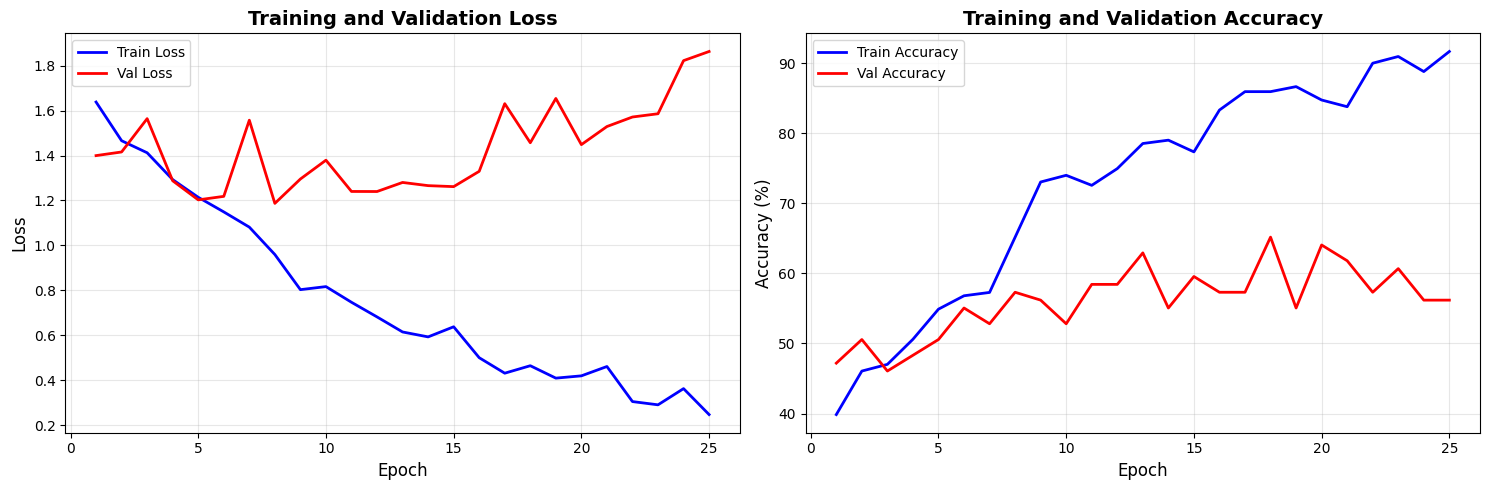

✓ Training curves saved!


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(history['train_loss']) + 1)

ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved!")

Loading best model...
Testing on held-out test set...


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

          CH       0.00      0.00      0.00         6
          CU       0.43      0.43      0.43         7
          FF       0.60      0.78      0.68        41
          SI       0.11      0.14      0.12         7
          SL       0.93      0.57      0.70        23
knucklecurve       0.25      0.29      0.27         7

    accuracy                           0.56        91
   macro avg       0.39      0.37      0.37        91
weighted avg       0.57      0.56      0.55        91



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


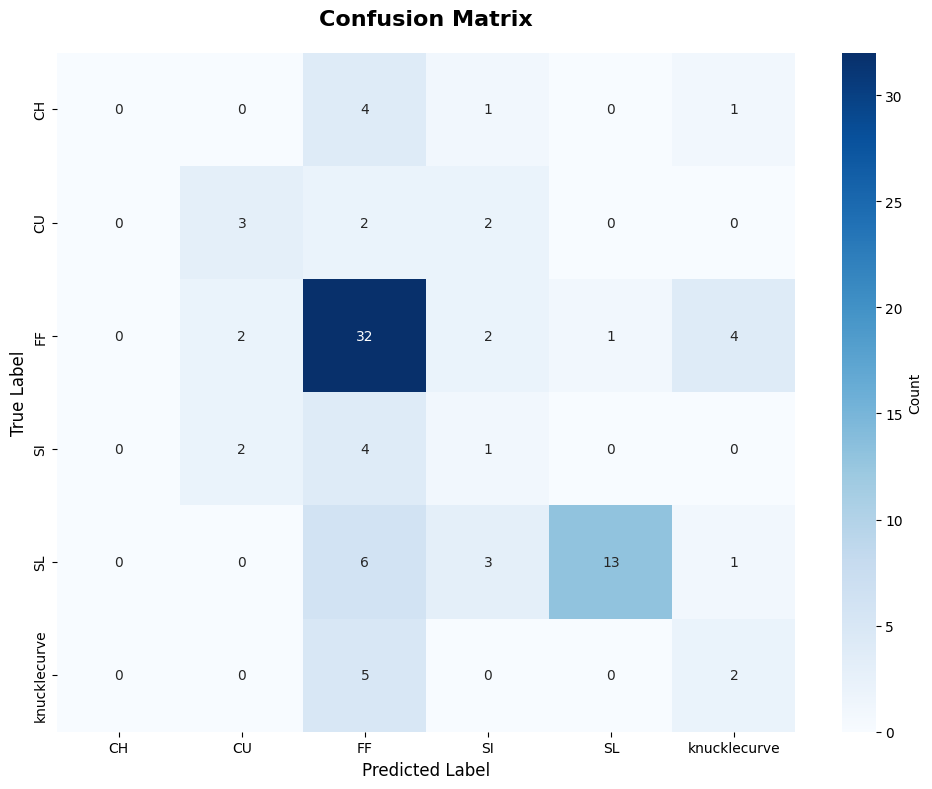


✓ Best validation accuracy: 65.17%
✓ Results saved to Google Drive: /content/drive/MyDrive/mlb_results


In [11]:
print("Loading best model...")
checkpoint = torch.load(os.path.join(CONFIG['model_save_dir'], 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Testing on held-out test set...")
all_preds = []
all_labels = []

with torch.no_grad():
    for videos, labels in tqdm(test_loader, desc="Testing"):
        videos = videos.to(device)
        outputs = model(videos)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(all_labels, all_preds,
                          target_names=full_dataset.pitch_types))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.pitch_types,
            yticklabels=full_dataset.pitch_types,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Best validation accuracy: {checkpoint['val_acc']:.2f}%")
print(f"✓ Results saved to Google Drive: {CONFIG['results_dir']}")

In [12]:
print("Creating results package...")

import json

results_summary = {
    'best_val_accuracy': float(best_val_acc),
    'num_epochs': CONFIG['num_epochs'],
    'num_classes': num_classes,
    'classes': full_dataset.pitch_types,
    'dataset_size': {
        'train': len(train_dataset),
        'val': len(val_dataset),
        'test': len(test_dataset)
    },
    'final_metrics': {
        'train_acc': float(history['train_acc'][-1]),
        'val_acc': float(history['val_acc'][-1])
    }
}

with open(os.path.join(CONFIG['results_dir'], 'results_summary.json'), 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results summary saved!")
print("\n" + "="*60)
print("ALL FILES SAVED TO GOOGLE DRIVE:")
print("="*60)
print(f"📁 Location: MyDrive/mlb_models/ and MyDrive/mlb_results/")
print("\nFiles created:")
print("best_model.pth (trained model)")
print("training_history.png (learning curves)")
print("confusion_matrix.png (classification results)")
print("results_summary.json (metrics)")
print("\nYou can download these from Google Drive or access them anytime!")

Creating results package...
✓ Results summary saved!

ALL FILES SAVED TO GOOGLE DRIVE:
📁 Location: MyDrive/mlb_models/ and MyDrive/mlb_results/

Files created:
  ✓ best_model.pth (trained model)
  ✓ training_history.png (learning curves)
  ✓ confusion_matrix.png (classification results)
  ✓ results_summary.json (metrics)

You can download these from Google Drive or access them anytime!
